In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, Normalizer

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima import auto_arima
import random
import itertools
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.decomposition import PCA, KernelPCA
from tqdm import tqdm
import itertools

seed = 77
regressors = [CatBoostRegressor(random_state=seed,n_estimators=5000),
             LGBMRegressor(random_state=seed),
             XGBRegressor(random_state=seed),
             ExtraTreeRegressor(random_state=seed),
             DecisionTreeRegressor(random_state=seed),
             RandomForestRegressor(random_state=seed)]

In [33]:
# sudo_date_pattern < 06-16 drop
# sudo_day_of_week
# sudo_night
# sudo_line_loc 
# rf	Random Forest Regressor	209.8683	196059.9855	439.1817	0.9689	0.1920	0.1138	9.4040
# xgboost	Extreme Gradient Boosting	261.2866	198893.7859	445.2230	0.9684	0.2313	0.1536	2.9780
# catboost	CatBoost Regressor	269.8176	202353.6340	449.0140	0.9679	0.2313	0.1593	4.6380
# et	Extra Trees Regressor	222.5143	206014.0346	450.6908	0.9673	0.1998	0.1226	6.3890
# lightgbm	Light Gradient Boosting Machine	334.9355	270773.8221	520.1849	0.9570	0.2624	0.2034	2.1770
# dt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        204000 non-null  float64
 5   풍속(m/s)        204000 non-null  float64
 6   습도(%)          204000 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


<AxesSubplot: >

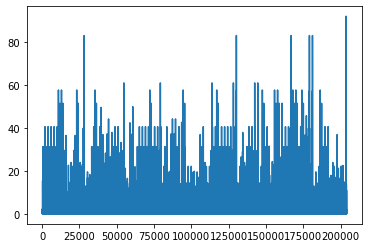

In [34]:
train = pd.read_csv('./train.csv')

tar = ['풍속(m/s)','습도(%)','강수량(mm)']
for i in tar:
    imp = IterativeImputer(random_state=seed)
    imp.fit(train[[i]])
    train[i] = imp.transform(train[[i]])

train.info()
train['강수량(mm)'].plot()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


<AxesSubplot: >

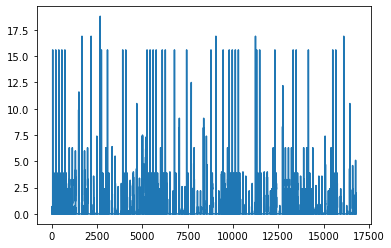

In [35]:
test = pd.read_csv('./test.csv')
test.info()
test['강수량(mm)'].plot()

In [38]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
building = pd.read_csv('./building_info.csv')

# train["date"] = train["num_date_time"].apply(lambda x: x.split("_")[1])
# train["date"] = pd.to_datetime(train["date"])
# test["date"] = test["num_date_time"].apply(lambda x: x.split("_")[1])
# test["date"] = pd.to_datetime(test["date"])

tar = ['풍속(m/s)','습도(%)','강수량(mm)']
for i in tar:
    imp = IterativeImputer(random_state=seed)
    imp.fit(train[[i]])
    train[i] = imp.transform(train[[i]])


train['month'] = train['일시'].apply(lambda x : float(x[4:6]))
train['day'] = train['일시'].apply(lambda x : float(x[6:8]))
train['time'] = train['일시'].apply(lambda x : float(x[9:11]))

test['month'] = test['일시'].apply(lambda x : float(x[4:6]))
test['day'] = test['일시'].apply(lambda x : float(x[6:8]))
test['time'] = test['일시'].apply(lambda x : float(x[9:11]))
train = train.drop(['num_date_time','강수량(mm)'],axis=1)
test = test.drop(['num_date_time','강수량(mm)'],axis=1)

train['일시'] = pd.to_datetime(train['일시'])
test['일시'] = pd.to_datetime(test['일시'])
# train = train[train['일시'] > '2022-06-17T23:00:00.000000000']

train = train.rename(columns={
    '일시': 'date'})

test = test.rename(columns={
    '일시': 'date'})

weekend = [0 for _ in range(len(train))]
for i in train.query('date.dt.dayofweek == 6').index:
    weekend[i] = 1
for i in train.query('date.dt.dayofweek == 5').index:
    weekend[i] = 1
train['sudo_weekend'] = weekend

weekend = [0 for _ in range(len(test))]
for i in test.query('date.dt.dayofweek == 6').index:
    weekend[i] = 1
for i in test.query('date.dt.dayofweek == 5').index:
    weekend[i] = 1
test['sudo_weekend'] = weekend


holiday = [f'2022-06-06 0{i}:00:00' for i in range(10)]
holiday.extend([f'2022-06-06 {i}:00:00' for i in range(10,24)])
holiday.extend([f'2022-08-15 0{i}:00:00' for i in range(10)])
holiday.extend([f'2022-08-15 {i}:00:00' for i in range(10,24)])
holy_idx = [train[train['date']==i].index for i in holiday]
ans = [0 for _ in range(len(train))]
for t in holy_idx:
    for idx in t:
        ans[idx] = 1
train['sudo_holiday'] = ans

holy_idx = [test[test['date']==i].index for i in holiday]
ans = [0 for _ in range(len(test))]
for t in holy_idx:
    for idx in t:
        ans[idx] = 1
test['sudo_holiday'] = ans



train = train.drop(['일조(hr)','일사(MJ/m2)'],axis=1)

train['풍속(m/s)'] = np.log10(train['풍속(m/s)']+2)
test['풍속(m/s)'] = np.log10(test['풍속(m/s)']+2)

train = pd.merge(train,building)
test = pd.merge(test,building)
train = train.drop(['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)'],axis=1)
test = test.drop(['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)'],axis=1)


MM = MinMaxScaler()
train['습도(%)'] = MM.fit_transform(np.array(train['습도(%)']).reshape(-1,1))
test['습도(%)'] = MM.fit_transform(np.array(test['습도(%)']).reshape(-1,1))

enc = OneHotEncoder()
enc.fit(train[['건물유형']])
tp = pd.DataFrame(data=enc.transform(train[['건물유형']]).toarray(),columns=enc.categories_[0])
train = pd.concat([train,tp],axis=1)

enc = OneHotEncoder()
enc.fit(test[['건물유형']])
tp = pd.DataFrame(data=enc.transform(test[['건물유형']]).toarray(),columns=enc.categories_[0])
test = pd.concat([test,tp],axis=1)

MM = MinMaxScaler()
train['연면적(m2)'] = MM.fit_transform(np.array(train['냉방면적(m2)']).reshape(-1,1))
test['연면적(m2)'] = MM.fit_transform(np.array(test['냉방면적(m2)']).reshape(-1,1))
train['냉방면적(m2)'] = MM.fit_transform(np.array(train['냉방면적(m2)']).reshape(-1,1))
test['냉방면적(m2)'] = MM.fit_transform(np.array(test['냉방면적(m2)']).reshape(-1,1))

target = ['기온(C)','풍속(m/s)']
enc = Normalizer()
for tar in target:
    train[tar] = MM.fit_transform(np.array(train[tar]).reshape(-1,1))
    test[tar] = MM.fit_transform(np.array(test[tar]).reshape(-1,1))
    

# enc = OneHotEncoder()
# target = '건물번호'
# enc.fit(train[[target]])
# tp = pd.DataFrame(data=enc.transform(train[[target]]).toarray(),columns=[str(i) for i in enc.categories_[0]])
# train = pd.concat([train,tp],axis=1)

# enc = OneHotEncoder()
# enc.fit(test[[target]])
# tp = pd.DataFrame(data=enc.transform(test[[target]]).toarray(),columns=[str(i) for i in enc.categories_[0]])
# test = pd.concat([test,tp],axis=1)

train = train.drop(['건물유형'],axis=1)
test = test.drop(['건물유형'],axis=1)

In [39]:
data_building = [train[train['건물번호'] == i] for i in range(1,101)]
data_building

[      건물번호                date     기온(C)   풍속(m/s)     습도(%)  전력소비량(kWh)  \
 0        1 2022-06-01 00:00:00  0.314815  0.182613  0.333333     1085.28   
 1        1 2022-06-01 01:00:00  0.292593  0.215390  0.367816     1047.36   
 2        1 2022-06-01 02:00:00  0.281481  0.275035  0.367816      974.88   
 3        1 2022-06-01 03:00:00  0.244444  0.260789  0.402299      953.76   
 4        1 2022-06-01 04:00:00  0.307407  0.430268  0.344828      986.40   
 ...    ...                 ...       ...       ...       ...         ...   
 2035     1 2022-08-24 19:00:00  0.570370  0.440402  0.574713     2517.12   
 2036     1 2022-08-24 20:00:00  0.551852  0.409351  0.609195     2208.96   
 2037     1 2022-08-24 21:00:00  0.537037  0.246117  0.620690     1806.24   
 2038     1 2022-08-24 22:00:00  0.518519  0.352798  0.655172     1387.20   
 2039     1 2022-08-24 23:00:00  0.507407  0.260789  0.655172     1925.28   
 
       month   day  time  sudo_weekend  ...  대학교  데이터센터  백화점및아울렛   병원   상용

In [41]:
# train.fillna(method=)
# imputer 


train_x = train[train['date'] < '2022-08-18 00:00:00']
train_y = train_x['전력소비량(kWh)']
train_x = train_x.drop('전력소비량(kWh)',axis=1)
valid_x = train[train['date'] >= '2022-08-18 00:00:00']
valid_y = valid_x['전력소비량(kWh)']
valid_x = valid_x.drop('전력소비량(kWh)',axis=1)

def smape(A, F):
    return 100 / len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

train_x = train_x.drop('date',axis=1)
valid_x = valid_x.drop('date',axis=1)

In [42]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187200 entries, 0 to 203831
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   건물번호          187200 non-null  int64  
 1   기온(C)         187200 non-null  float64
 2   풍속(m/s)       187200 non-null  float64
 3   습도(%)         187200 non-null  float64
 4   month         187200 non-null  float64
 5   day           187200 non-null  float64
 6   time          187200 non-null  float64
 7   sudo_weekend  187200 non-null  int64  
 8   sudo_holiday  187200 non-null  int64  
 9   연면적(m2)       187200 non-null  float64
 10  냉방면적(m2)      187200 non-null  float64
 11  건물기타          187200 non-null  float64
 12  공공            187200 non-null  float64
 13  대학교           187200 non-null  float64
 14  데이터센터         187200 non-null  float64
 15  백화점및아울렛       187200 non-null  float64
 16  병원            187200 non-null  float64
 17  상용            187200 non-null  float64
 18  아파트 

In [45]:
train_x = train.drop('date',axis=1)
train_y = train['전력소비량(kWh)']
train_x = train_x.drop('전력소비량(kWh)',axis=1)

regressors[-1].fit(train_x, train_y)

RandomForestRegressor(random_state=77)

In [50]:
smape(regressors[-1].predict(valid_x),valid_y)

0.7890497824395408

In [27]:
log = []
for regressor in tqdm(regressors):
    regressor.fit(train_x, train_y)
    pred = regressor.predict(valid_x)
    log.append([regressor,smape(valid_y, pred)])

pd.DataFrame(log)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Learning rate set to 0.02529
0:	learn: 2392.4132917	total: 35.7ms	remaining: 2m 58s
1:	learn: 2348.4882580	total: 65.7ms	remaining: 2m 44s
2:	learn: 2305.9921561	total: 93.7ms	remaining: 2m 36s
3:	learn: 2264.9250753	total: 123ms	remaining: 2m 33s
4:	learn: 2223.3684832	total: 153ms	remaining: 2m 32s
5:	learn: 2184.7695995	total: 179ms	remaining: 2m 29s
6:	learn: 2146.3718324	total: 210ms	remaining: 2m 29s
7:	learn: 2108.6057659	total: 241ms	remaining: 2m 30s
8:	learn: 2072.0842912	total: 271ms	remaining: 2m 30s
9:	learn: 2038.3408557	total: 297ms	remaining: 2m 28s
10:	learn: 2004.4431280	total: 327ms	remaining: 2m 28s
11:	learn: 1973.3189568	total: 353ms	remaining: 2m 26s
12:	learn: 1942.9352334	total: 382ms	remaining: 2m 26s
13:	learn: 1913.4099675	total: 412ms	remaining: 2m 26s
14:	learn: 1885.4740086	total: 440ms	remaining: 2m 26s
15:	learn: 1856.6713951	total: 468ms	remaining: 2m 25s
16:	learn: 1828.8173936	total: 499ms	remaining: 2m 26s
17:	learn: 1803.3732020	total: 525ms	remain

149:	learn: 883.1467750	total: 4.28s	remaining: 2m 18s
150:	learn: 881.1843083	total: 4.31s	remaining: 2m 18s
151:	learn: 878.5707991	total: 4.33s	remaining: 2m 18s
152:	learn: 877.2431397	total: 4.36s	remaining: 2m 18s
153:	learn: 874.7042363	total: 4.39s	remaining: 2m 18s
154:	learn: 872.4253478	total: 4.41s	remaining: 2m 17s
155:	learn: 870.7492547	total: 4.44s	remaining: 2m 17s
156:	learn: 869.4591218	total: 4.47s	remaining: 2m 17s
157:	learn: 867.2998251	total: 4.49s	remaining: 2m 17s
158:	learn: 865.6762863	total: 4.52s	remaining: 2m 17s
159:	learn: 863.6288361	total: 4.54s	remaining: 2m 17s
160:	learn: 861.9445880	total: 4.56s	remaining: 2m 17s
161:	learn: 859.6919081	total: 4.58s	remaining: 2m 16s
162:	learn: 857.6859357	total: 4.61s	remaining: 2m 16s
163:	learn: 856.0600570	total: 4.64s	remaining: 2m 16s
164:	learn: 854.5290995	total: 4.66s	remaining: 2m 16s
165:	learn: 852.6109473	total: 4.69s	remaining: 2m 16s
166:	learn: 850.7144086	total: 4.72s	remaining: 2m 16s
167:	learn

305:	learn: 705.1345105	total: 8.47s	remaining: 2m 10s
306:	learn: 704.3094013	total: 8.51s	remaining: 2m 10s
307:	learn: 703.6111025	total: 8.53s	remaining: 2m 10s
308:	learn: 702.9056058	total: 8.56s	remaining: 2m 10s
309:	learn: 702.2733662	total: 8.59s	remaining: 2m 10s
310:	learn: 701.4435580	total: 8.62s	remaining: 2m 10s
311:	learn: 700.7795171	total: 8.65s	remaining: 2m 10s
312:	learn: 700.2139781	total: 8.68s	remaining: 2m 10s
313:	learn: 699.7536914	total: 8.71s	remaining: 2m 9s
314:	learn: 699.0167634	total: 8.74s	remaining: 2m 9s
315:	learn: 698.1973539	total: 8.77s	remaining: 2m 9s
316:	learn: 697.4880025	total: 8.8s	remaining: 2m 9s
317:	learn: 697.0918556	total: 8.83s	remaining: 2m 9s
318:	learn: 696.4874549	total: 8.85s	remaining: 2m 9s
319:	learn: 696.0066085	total: 8.88s	remaining: 2m 9s
320:	learn: 695.4981807	total: 8.91s	remaining: 2m 9s
321:	learn: 695.0930115	total: 8.94s	remaining: 2m 9s
322:	learn: 694.5359501	total: 8.97s	remaining: 2m 9s
323:	learn: 693.83274

462:	learn: 625.6321683	total: 12.8s	remaining: 2m 5s
463:	learn: 625.3337300	total: 12.9s	remaining: 2m 5s
464:	learn: 625.0385894	total: 12.9s	remaining: 2m 5s
465:	learn: 624.7671115	total: 12.9s	remaining: 2m 5s
466:	learn: 624.3923319	total: 12.9s	remaining: 2m 5s
467:	learn: 624.0974882	total: 13s	remaining: 2m 5s
468:	learn: 623.7496410	total: 13s	remaining: 2m 5s
469:	learn: 623.3398759	total: 13s	remaining: 2m 5s
470:	learn: 623.0669913	total: 13.1s	remaining: 2m 5s
471:	learn: 622.8495428	total: 13.1s	remaining: 2m 5s
472:	learn: 622.5513730	total: 13.1s	remaining: 2m 5s
473:	learn: 622.2228940	total: 13.1s	remaining: 2m 5s
474:	learn: 621.9225443	total: 13.2s	remaining: 2m 5s
475:	learn: 621.5651144	total: 13.2s	remaining: 2m 5s
476:	learn: 621.1398118	total: 13.2s	remaining: 2m 5s
477:	learn: 620.8416593	total: 13.3s	remaining: 2m 5s
478:	learn: 620.4280645	total: 13.3s	remaining: 2m 5s
479:	learn: 620.1392657	total: 13.3s	remaining: 2m 5s
480:	learn: 619.8140938	total: 13.

616:	learn: 578.4882236	total: 17.2s	remaining: 2m 2s
617:	learn: 578.3048594	total: 17.3s	remaining: 2m 2s
618:	learn: 578.0761392	total: 17.3s	remaining: 2m 2s
619:	learn: 577.8910779	total: 17.3s	remaining: 2m 2s
620:	learn: 577.6714167	total: 17.4s	remaining: 2m 2s
621:	learn: 577.4526186	total: 17.4s	remaining: 2m 2s
622:	learn: 577.2328991	total: 17.4s	remaining: 2m 2s
623:	learn: 577.0141634	total: 17.4s	remaining: 2m 2s
624:	learn: 576.8025175	total: 17.5s	remaining: 2m 2s
625:	learn: 576.5590361	total: 17.5s	remaining: 2m 2s
626:	learn: 576.2895363	total: 17.5s	remaining: 2m 2s
627:	learn: 576.0340460	total: 17.5s	remaining: 2m 2s
628:	learn: 575.8633256	total: 17.6s	remaining: 2m 2s
629:	learn: 575.6359605	total: 17.6s	remaining: 2m 2s
630:	learn: 575.3806935	total: 17.6s	remaining: 2m 1s
631:	learn: 575.1148959	total: 17.6s	remaining: 2m 1s
632:	learn: 574.9337216	total: 17.7s	remaining: 2m 1s
633:	learn: 574.7608973	total: 17.7s	remaining: 2m 1s
634:	learn: 574.5074320	tota

773:	learn: 546.2450834	total: 21.6s	remaining: 1m 58s
774:	learn: 545.9994426	total: 21.6s	remaining: 1m 58s
775:	learn: 545.9088810	total: 21.7s	remaining: 1m 57s
776:	learn: 545.7676372	total: 21.7s	remaining: 1m 57s
777:	learn: 545.5210814	total: 21.7s	remaining: 1m 57s
778:	learn: 545.3826348	total: 21.8s	remaining: 1m 57s
779:	learn: 545.2236186	total: 21.8s	remaining: 1m 57s
780:	learn: 544.9961258	total: 21.8s	remaining: 1m 57s
781:	learn: 544.8622409	total: 21.8s	remaining: 1m 57s
782:	learn: 544.7139118	total: 21.9s	remaining: 1m 57s
783:	learn: 544.4787263	total: 21.9s	remaining: 1m 57s
784:	learn: 544.3511776	total: 21.9s	remaining: 1m 57s
785:	learn: 544.1330261	total: 22s	remaining: 1m 57s
786:	learn: 543.9497148	total: 22s	remaining: 1m 57s
787:	learn: 543.8363873	total: 22s	remaining: 1m 57s
788:	learn: 543.7067129	total: 22s	remaining: 1m 57s
789:	learn: 543.5815534	total: 22.1s	remaining: 1m 57s
790:	learn: 543.4285638	total: 22.1s	remaining: 1m 57s
791:	learn: 543.31

926:	learn: 523.1797028	total: 26s	remaining: 1m 54s
927:	learn: 523.0157428	total: 26.1s	remaining: 1m 54s
928:	learn: 522.8392695	total: 26.1s	remaining: 1m 54s
929:	learn: 522.7518719	total: 26.1s	remaining: 1m 54s
930:	learn: 522.3759360	total: 26.2s	remaining: 1m 54s
931:	learn: 522.3150599	total: 26.2s	remaining: 1m 54s
932:	learn: 521.9568249	total: 26.2s	remaining: 1m 54s
933:	learn: 521.8527671	total: 26.3s	remaining: 1m 54s
934:	learn: 521.7026689	total: 26.3s	remaining: 1m 54s
935:	learn: 521.5345183	total: 26.3s	remaining: 1m 54s
936:	learn: 521.3355072	total: 26.3s	remaining: 1m 54s
937:	learn: 521.2091380	total: 26.4s	remaining: 1m 54s
938:	learn: 521.1306234	total: 26.4s	remaining: 1m 54s
939:	learn: 521.0085606	total: 26.4s	remaining: 1m 54s
940:	learn: 520.9341440	total: 26.5s	remaining: 1m 54s
941:	learn: 520.8293707	total: 26.5s	remaining: 1m 54s
942:	learn: 520.7013191	total: 26.5s	remaining: 1m 54s
943:	learn: 520.6107418	total: 26.5s	remaining: 1m 54s
944:	learn: 

1075:	learn: 504.4848771	total: 30.4s	remaining: 1m 50s
1076:	learn: 504.3717618	total: 30.5s	remaining: 1m 50s
1077:	learn: 504.2576601	total: 30.5s	remaining: 1m 50s
1078:	learn: 504.2054437	total: 30.5s	remaining: 1m 50s
1079:	learn: 504.1456789	total: 30.5s	remaining: 1m 50s
1080:	learn: 504.0510981	total: 30.6s	remaining: 1m 50s
1081:	learn: 503.9594275	total: 30.6s	remaining: 1m 50s
1082:	learn: 503.8124368	total: 30.6s	remaining: 1m 50s
1083:	learn: 503.7072532	total: 30.7s	remaining: 1m 50s
1084:	learn: 503.5896125	total: 30.7s	remaining: 1m 50s
1085:	learn: 503.4333462	total: 30.7s	remaining: 1m 50s
1086:	learn: 503.1710922	total: 30.8s	remaining: 1m 50s
1087:	learn: 503.1119206	total: 30.8s	remaining: 1m 50s
1088:	learn: 503.0261047	total: 30.8s	remaining: 1m 50s
1089:	learn: 502.9415833	total: 30.9s	remaining: 1m 50s
1090:	learn: 502.8736382	total: 30.9s	remaining: 1m 50s
1091:	learn: 502.7767129	total: 30.9s	remaining: 1m 50s
1092:	learn: 502.6670880	total: 30.9s	remaining:

1224:	learn: 488.5167955	total: 34.8s	remaining: 1m 47s
1225:	learn: 488.4281320	total: 34.9s	remaining: 1m 47s
1226:	learn: 488.3609544	total: 34.9s	remaining: 1m 47s
1227:	learn: 488.2880705	total: 34.9s	remaining: 1m 47s
1228:	learn: 488.1807633	total: 35s	remaining: 1m 47s
1229:	learn: 488.1146910	total: 35s	remaining: 1m 47s
1230:	learn: 488.0442822	total: 35s	remaining: 1m 47s
1231:	learn: 487.9554432	total: 35s	remaining: 1m 47s
1232:	learn: 487.8644718	total: 35.1s	remaining: 1m 47s
1233:	learn: 487.8015754	total: 35.1s	remaining: 1m 47s
1234:	learn: 487.7061829	total: 35.1s	remaining: 1m 47s
1235:	learn: 487.5829320	total: 35.2s	remaining: 1m 47s
1236:	learn: 487.5120732	total: 35.2s	remaining: 1m 47s
1237:	learn: 487.4367738	total: 35.2s	remaining: 1m 47s
1238:	learn: 487.3519581	total: 35.3s	remaining: 1m 47s
1239:	learn: 487.2456687	total: 35.3s	remaining: 1m 46s
1240:	learn: 487.2026982	total: 35.3s	remaining: 1m 46s
1241:	learn: 487.1383523	total: 35.3s	remaining: 1m 46s


1375:	learn: 475.1081283	total: 39.3s	remaining: 1m 43s
1376:	learn: 475.0340454	total: 39.4s	remaining: 1m 43s
1377:	learn: 474.9429936	total: 39.4s	remaining: 1m 43s
1378:	learn: 474.8946921	total: 39.4s	remaining: 1m 43s
1379:	learn: 474.8392059	total: 39.5s	remaining: 1m 43s
1380:	learn: 474.7759010	total: 39.5s	remaining: 1m 43s
1381:	learn: 474.6815379	total: 39.5s	remaining: 1m 43s
1382:	learn: 474.5297230	total: 39.5s	remaining: 1m 43s
1383:	learn: 474.4433464	total: 39.6s	remaining: 1m 43s
1384:	learn: 474.3562696	total: 39.6s	remaining: 1m 43s
1385:	learn: 474.2926993	total: 39.6s	remaining: 1m 43s
1386:	learn: 474.2113289	total: 39.7s	remaining: 1m 43s
1387:	learn: 474.1508843	total: 39.7s	remaining: 1m 43s
1388:	learn: 474.0545847	total: 39.7s	remaining: 1m 43s
1389:	learn: 474.0153752	total: 39.8s	remaining: 1m 43s
1390:	learn: 473.9351551	total: 39.8s	remaining: 1m 43s
1391:	learn: 473.8426267	total: 39.8s	remaining: 1m 43s
1392:	learn: 473.8024175	total: 39.8s	remaining:

1528:	learn: 462.7390817	total: 44s	remaining: 1m 39s
1529:	learn: 462.6683222	total: 44s	remaining: 1m 39s
1530:	learn: 462.6358822	total: 44s	remaining: 1m 39s
1531:	learn: 462.5979811	total: 44s	remaining: 1m 39s
1532:	learn: 462.5773966	total: 44.1s	remaining: 1m 39s
1533:	learn: 462.5347951	total: 44.1s	remaining: 1m 39s
1534:	learn: 462.3657975	total: 44.1s	remaining: 1m 39s
1535:	learn: 462.1850272	total: 44.2s	remaining: 1m 39s
1536:	learn: 462.1604182	total: 44.2s	remaining: 1m 39s
1537:	learn: 462.0872770	total: 44.2s	remaining: 1m 39s
1538:	learn: 462.0432431	total: 44.3s	remaining: 1m 39s
1539:	learn: 461.9578287	total: 44.3s	remaining: 1m 39s
1540:	learn: 461.8451914	total: 44.3s	remaining: 1m 39s
1541:	learn: 461.7805008	total: 44.3s	remaining: 1m 39s
1542:	learn: 461.6761208	total: 44.4s	remaining: 1m 39s
1543:	learn: 461.6020666	total: 44.4s	remaining: 1m 39s
1544:	learn: 461.5404284	total: 44.4s	remaining: 1m 39s
1545:	learn: 461.4698828	total: 44.5s	remaining: 1m 39s


1681:	learn: 451.6243946	total: 48.6s	remaining: 1m 35s
1682:	learn: 451.5874106	total: 48.6s	remaining: 1m 35s
1683:	learn: 451.5038473	total: 48.6s	remaining: 1m 35s
1684:	learn: 451.3515666	total: 48.6s	remaining: 1m 35s
1685:	learn: 451.2990729	total: 48.7s	remaining: 1m 35s
1686:	learn: 451.2469266	total: 48.7s	remaining: 1m 35s
1687:	learn: 451.1656903	total: 48.7s	remaining: 1m 35s
1688:	learn: 451.1135527	total: 48.8s	remaining: 1m 35s
1689:	learn: 451.0551154	total: 48.8s	remaining: 1m 35s
1690:	learn: 450.8524207	total: 48.8s	remaining: 1m 35s
1691:	learn: 450.7954491	total: 48.9s	remaining: 1m 35s
1692:	learn: 450.7461775	total: 48.9s	remaining: 1m 35s
1693:	learn: 450.6868520	total: 48.9s	remaining: 1m 35s
1694:	learn: 450.6508680	total: 49s	remaining: 1m 35s
1695:	learn: 450.5963130	total: 49s	remaining: 1m 35s
1696:	learn: 450.5260535	total: 49s	remaining: 1m 35s
1697:	learn: 450.4281959	total: 49s	remaining: 1m 35s
1698:	learn: 450.3857693	total: 49.1s	remaining: 1m 35s


1829:	learn: 442.3424798	total: 53.2s	remaining: 1m 32s
1830:	learn: 442.2902978	total: 53.2s	remaining: 1m 32s
1831:	learn: 442.2472811	total: 53.2s	remaining: 1m 32s
1832:	learn: 442.2105066	total: 53.3s	remaining: 1m 32s
1833:	learn: 442.1803159	total: 53.3s	remaining: 1m 32s
1834:	learn: 442.1330419	total: 53.3s	remaining: 1m 31s
1835:	learn: 442.0319801	total: 53.4s	remaining: 1m 31s
1836:	learn: 441.9926642	total: 53.4s	remaining: 1m 31s
1837:	learn: 441.9305426	total: 53.4s	remaining: 1m 31s
1838:	learn: 441.8856602	total: 53.5s	remaining: 1m 31s
1839:	learn: 441.8313896	total: 53.5s	remaining: 1m 31s
1840:	learn: 441.7599579	total: 53.5s	remaining: 1m 31s
1841:	learn: 441.6516645	total: 53.6s	remaining: 1m 31s
1842:	learn: 441.5868360	total: 53.6s	remaining: 1m 31s
1843:	learn: 441.5309250	total: 53.6s	remaining: 1m 31s
1844:	learn: 441.4807987	total: 53.6s	remaining: 1m 31s
1845:	learn: 441.4369082	total: 53.7s	remaining: 1m 31s
1846:	learn: 441.3589123	total: 53.7s	remaining:

1977:	learn: 434.7643213	total: 57.8s	remaining: 1m 28s
1978:	learn: 434.7220993	total: 57.8s	remaining: 1m 28s
1979:	learn: 434.6992326	total: 57.9s	remaining: 1m 28s
1980:	learn: 434.6369954	total: 57.9s	remaining: 1m 28s
1981:	learn: 434.6041109	total: 57.9s	remaining: 1m 28s
1982:	learn: 434.5296635	total: 58s	remaining: 1m 28s
1983:	learn: 434.4939673	total: 58s	remaining: 1m 28s
1984:	learn: 434.4238513	total: 58s	remaining: 1m 28s
1985:	learn: 434.3658970	total: 58.1s	remaining: 1m 28s
1986:	learn: 434.3319929	total: 58.1s	remaining: 1m 28s
1987:	learn: 434.2950171	total: 58.1s	remaining: 1m 28s
1988:	learn: 434.2607323	total: 58.1s	remaining: 1m 28s
1989:	learn: 434.2121832	total: 58.2s	remaining: 1m 28s
1990:	learn: 434.1864082	total: 58.2s	remaining: 1m 27s
1991:	learn: 434.1101873	total: 58.2s	remaining: 1m 27s
1992:	learn: 434.0325106	total: 58.3s	remaining: 1m 27s
1993:	learn: 433.9898468	total: 58.3s	remaining: 1m 27s
1994:	learn: 433.9686711	total: 58.3s	remaining: 1m 27

2131:	learn: 427.7644342	total: 1m 2s	remaining: 1m 24s
2132:	learn: 427.7410314	total: 1m 2s	remaining: 1m 24s
2133:	learn: 427.7074272	total: 1m 2s	remaining: 1m 24s
2134:	learn: 427.6809632	total: 1m 2s	remaining: 1m 24s
2135:	learn: 427.6267469	total: 1m 2s	remaining: 1m 24s
2136:	learn: 427.5705728	total: 1m 2s	remaining: 1m 24s
2137:	learn: 427.5274320	total: 1m 2s	remaining: 1m 24s
2138:	learn: 427.4907321	total: 1m 2s	remaining: 1m 24s
2139:	learn: 427.4564341	total: 1m 2s	remaining: 1m 24s
2140:	learn: 427.4281243	total: 1m 2s	remaining: 1m 23s
2141:	learn: 427.3829521	total: 1m 2s	remaining: 1m 23s
2142:	learn: 427.3067882	total: 1m 2s	remaining: 1m 23s
2143:	learn: 427.2461755	total: 1m 2s	remaining: 1m 23s
2144:	learn: 427.2145947	total: 1m 3s	remaining: 1m 23s
2145:	learn: 427.1368837	total: 1m 3s	remaining: 1m 23s
2146:	learn: 427.0938719	total: 1m 3s	remaining: 1m 23s
2147:	learn: 427.0379995	total: 1m 3s	remaining: 1m 23s
2148:	learn: 426.9872231	total: 1m 3s	remaining:

2278:	learn: 421.7146174	total: 1m 7s	remaining: 1m 20s
2279:	learn: 421.6497606	total: 1m 7s	remaining: 1m 20s
2280:	learn: 421.6266764	total: 1m 7s	remaining: 1m 20s
2281:	learn: 421.6154470	total: 1m 7s	remaining: 1m 20s
2282:	learn: 421.5795931	total: 1m 7s	remaining: 1m 20s
2283:	learn: 421.4750619	total: 1m 7s	remaining: 1m 20s
2284:	learn: 421.4302004	total: 1m 7s	remaining: 1m 20s
2285:	learn: 421.3452829	total: 1m 7s	remaining: 1m 20s
2286:	learn: 421.3003760	total: 1m 7s	remaining: 1m 20s
2287:	learn: 421.2799773	total: 1m 7s	remaining: 1m 20s
2288:	learn: 421.2452101	total: 1m 7s	remaining: 1m 20s
2289:	learn: 421.1950180	total: 1m 7s	remaining: 1m 20s
2290:	learn: 421.1689961	total: 1m 7s	remaining: 1m 19s
2291:	learn: 421.1078263	total: 1m 7s	remaining: 1m 19s
2292:	learn: 421.0833644	total: 1m 7s	remaining: 1m 19s
2293:	learn: 421.0172063	total: 1m 7s	remaining: 1m 19s
2294:	learn: 420.9690961	total: 1m 7s	remaining: 1m 19s
2295:	learn: 420.9431120	total: 1m 7s	remaining:

2426:	learn: 415.5870384	total: 1m 11s	remaining: 1m 16s
2427:	learn: 415.5638349	total: 1m 11s	remaining: 1m 16s
2428:	learn: 415.5245453	total: 1m 11s	remaining: 1m 16s
2429:	learn: 415.4944816	total: 1m 11s	remaining: 1m 16s
2430:	learn: 415.4581413	total: 1m 12s	remaining: 1m 16s
2431:	learn: 415.4157927	total: 1m 12s	remaining: 1m 16s
2432:	learn: 415.3797787	total: 1m 12s	remaining: 1m 16s
2433:	learn: 415.3435574	total: 1m 12s	remaining: 1m 16s
2434:	learn: 415.3205767	total: 1m 12s	remaining: 1m 15s
2435:	learn: 415.2959942	total: 1m 12s	remaining: 1m 15s
2436:	learn: 415.2708598	total: 1m 12s	remaining: 1m 15s
2437:	learn: 415.2210403	total: 1m 12s	remaining: 1m 15s
2438:	learn: 415.1939132	total: 1m 12s	remaining: 1m 15s
2439:	learn: 415.1667209	total: 1m 12s	remaining: 1m 15s
2440:	learn: 415.1239597	total: 1m 12s	remaining: 1m 15s
2441:	learn: 415.0866868	total: 1m 12s	remaining: 1m 15s
2442:	learn: 415.0592316	total: 1m 12s	remaining: 1m 15s
2443:	learn: 414.9859628	total:

2574:	learn: 410.5022510	total: 1m 16s	remaining: 1m 12s
2575:	learn: 410.4423221	total: 1m 16s	remaining: 1m 12s
2576:	learn: 410.4162823	total: 1m 16s	remaining: 1m 11s
2577:	learn: 410.3816902	total: 1m 16s	remaining: 1m 11s
2578:	learn: 410.3630270	total: 1m 16s	remaining: 1m 11s
2579:	learn: 410.3434754	total: 1m 16s	remaining: 1m 11s
2580:	learn: 410.3061436	total: 1m 16s	remaining: 1m 11s
2581:	learn: 410.2715895	total: 1m 16s	remaining: 1m 11s
2582:	learn: 410.2234504	total: 1m 16s	remaining: 1m 11s
2583:	learn: 410.2086541	total: 1m 16s	remaining: 1m 11s
2584:	learn: 410.1831060	total: 1m 16s	remaining: 1m 11s
2585:	learn: 410.1262987	total: 1m 16s	remaining: 1m 11s
2586:	learn: 410.0906864	total: 1m 16s	remaining: 1m 11s
2587:	learn: 410.0216747	total: 1m 16s	remaining: 1m 11s
2588:	learn: 409.9739168	total: 1m 16s	remaining: 1m 11s
2589:	learn: 409.9434048	total: 1m 16s	remaining: 1m 11s
2590:	learn: 409.9148614	total: 1m 17s	remaining: 1m 11s
2591:	learn: 409.8864927	total:

2721:	learn: 405.1499886	total: 1m 21s	remaining: 1m 7s
2722:	learn: 405.1160151	total: 1m 21s	remaining: 1m 7s
2723:	learn: 405.0873034	total: 1m 21s	remaining: 1m 7s
2724:	learn: 405.0684349	total: 1m 21s	remaining: 1m 7s
2725:	learn: 405.0326609	total: 1m 21s	remaining: 1m 7s
2726:	learn: 405.0004945	total: 1m 21s	remaining: 1m 7s
2727:	learn: 404.9772668	total: 1m 21s	remaining: 1m 7s
2728:	learn: 404.9423437	total: 1m 21s	remaining: 1m 7s
2729:	learn: 404.9166958	total: 1m 21s	remaining: 1m 7s
2730:	learn: 404.8853068	total: 1m 21s	remaining: 1m 7s
2731:	learn: 404.8474355	total: 1m 21s	remaining: 1m 7s
2732:	learn: 404.8259250	total: 1m 21s	remaining: 1m 7s
2733:	learn: 404.7777581	total: 1m 21s	remaining: 1m 7s
2734:	learn: 404.7489236	total: 1m 21s	remaining: 1m 7s
2735:	learn: 404.7181265	total: 1m 21s	remaining: 1m 7s
2736:	learn: 404.6516646	total: 1m 21s	remaining: 1m 7s
2737:	learn: 404.6235679	total: 1m 21s	remaining: 1m 7s
2738:	learn: 404.5672265	total: 1m 21s	remaining

2869:	learn: 400.8641953	total: 1m 25s	remaining: 1m 3s
2870:	learn: 400.8464659	total: 1m 25s	remaining: 1m 3s
2871:	learn: 400.8303043	total: 1m 25s	remaining: 1m 3s
2872:	learn: 400.7945366	total: 1m 25s	remaining: 1m 3s
2873:	learn: 400.7671273	total: 1m 25s	remaining: 1m 3s
2874:	learn: 400.7466205	total: 1m 25s	remaining: 1m 3s
2875:	learn: 400.7125492	total: 1m 25s	remaining: 1m 3s
2876:	learn: 400.6728914	total: 1m 25s	remaining: 1m 3s
2877:	learn: 400.6348253	total: 1m 25s	remaining: 1m 3s
2878:	learn: 400.6192933	total: 1m 25s	remaining: 1m 3s
2879:	learn: 400.5859335	total: 1m 25s	remaining: 1m 3s
2880:	learn: 400.5691926	total: 1m 26s	remaining: 1m 3s
2881:	learn: 400.5323235	total: 1m 26s	remaining: 1m 3s
2882:	learn: 400.5188288	total: 1m 26s	remaining: 1m 3s
2883:	learn: 400.4916749	total: 1m 26s	remaining: 1m 3s
2884:	learn: 400.4706094	total: 1m 26s	remaining: 1m 3s
2885:	learn: 400.4350140	total: 1m 26s	remaining: 1m 3s
2886:	learn: 400.4138471	total: 1m 26s	remaining

3024:	learn: 395.9707629	total: 1m 30s	remaining: 59.1s
3025:	learn: 395.9522488	total: 1m 30s	remaining: 59.1s
3026:	learn: 395.9102925	total: 1m 30s	remaining: 59.1s
3027:	learn: 395.8729340	total: 1m 30s	remaining: 59s
3028:	learn: 395.8546747	total: 1m 30s	remaining: 59s
3029:	learn: 395.8447908	total: 1m 30s	remaining: 59s
3030:	learn: 395.8140423	total: 1m 30s	remaining: 58.9s
3031:	learn: 395.7530493	total: 1m 30s	remaining: 58.9s
3032:	learn: 395.7362295	total: 1m 30s	remaining: 58.9s
3033:	learn: 395.6870386	total: 1m 30s	remaining: 58.8s
3034:	learn: 395.6698898	total: 1m 30s	remaining: 58.8s
3035:	learn: 395.6395002	total: 1m 30s	remaining: 58.8s
3036:	learn: 395.6222096	total: 1m 30s	remaining: 58.8s
3037:	learn: 395.5866292	total: 1m 30s	remaining: 58.7s
3038:	learn: 395.5688915	total: 1m 30s	remaining: 58.7s
3039:	learn: 395.5398495	total: 1m 31s	remaining: 58.7s
3040:	learn: 395.5240692	total: 1m 31s	remaining: 58.6s
3041:	learn: 395.5035728	total: 1m 31s	remaining: 58.6

3172:	learn: 391.7241438	total: 1m 35s	remaining: 54.8s
3173:	learn: 391.7151615	total: 1m 35s	remaining: 54.7s
3174:	learn: 391.6503122	total: 1m 35s	remaining: 54.7s
3175:	learn: 391.6230896	total: 1m 35s	remaining: 54.7s
3176:	learn: 391.6163225	total: 1m 35s	remaining: 54.6s
3177:	learn: 391.6071922	total: 1m 35s	remaining: 54.6s
3178:	learn: 391.5768073	total: 1m 35s	remaining: 54.6s
3179:	learn: 391.5567216	total: 1m 35s	remaining: 54.6s
3180:	learn: 391.5236450	total: 1m 35s	remaining: 54.5s
3181:	learn: 391.5043047	total: 1m 35s	remaining: 54.5s
3182:	learn: 391.4133631	total: 1m 35s	remaining: 54.5s
3183:	learn: 391.3877662	total: 1m 35s	remaining: 54.4s
3184:	learn: 391.3726176	total: 1m 35s	remaining: 54.4s
3185:	learn: 391.3470777	total: 1m 35s	remaining: 54.4s
3186:	learn: 391.3306518	total: 1m 35s	remaining: 54.4s
3187:	learn: 391.3190878	total: 1m 35s	remaining: 54.3s
3188:	learn: 391.2610893	total: 1m 35s	remaining: 54.3s
3189:	learn: 391.2458064	total: 1m 35s	remaining

3325:	learn: 386.9289702	total: 1m 39s	remaining: 50.3s
3326:	learn: 386.9155360	total: 1m 39s	remaining: 50.2s
3327:	learn: 386.8995371	total: 1m 39s	remaining: 50.2s
3328:	learn: 386.8849883	total: 1m 39s	remaining: 50.2s
3329:	learn: 386.8564920	total: 1m 40s	remaining: 50.2s
3330:	learn: 386.8224865	total: 1m 40s	remaining: 50.1s
3331:	learn: 386.7943114	total: 1m 40s	remaining: 50.1s
3332:	learn: 386.7192978	total: 1m 40s	remaining: 50.1s
3333:	learn: 386.6859573	total: 1m 40s	remaining: 50s
3334:	learn: 386.6737357	total: 1m 40s	remaining: 50s
3335:	learn: 386.6630739	total: 1m 40s	remaining: 50s
3336:	learn: 386.6347936	total: 1m 40s	remaining: 50s
3337:	learn: 386.5911024	total: 1m 40s	remaining: 49.9s
3338:	learn: 386.5356838	total: 1m 40s	remaining: 49.9s
3339:	learn: 386.5226246	total: 1m 40s	remaining: 49.9s
3340:	learn: 386.5025373	total: 1m 40s	remaining: 49.8s
3341:	learn: 386.4758870	total: 1m 40s	remaining: 49.8s
3342:	learn: 386.4417444	total: 1m 40s	remaining: 49.8s


3474:	learn: 382.7580137	total: 1m 44s	remaining: 45.9s
3475:	learn: 382.7429165	total: 1m 44s	remaining: 45.8s
3476:	learn: 382.7150519	total: 1m 44s	remaining: 45.8s
3477:	learn: 382.6996064	total: 1m 44s	remaining: 45.8s
3478:	learn: 382.6825632	total: 1m 44s	remaining: 45.8s
3479:	learn: 382.6536044	total: 1m 44s	remaining: 45.7s
3480:	learn: 382.6022685	total: 1m 44s	remaining: 45.7s
3481:	learn: 382.5689354	total: 1m 44s	remaining: 45.7s
3482:	learn: 382.5620102	total: 1m 44s	remaining: 45.6s
3483:	learn: 382.5327262	total: 1m 44s	remaining: 45.6s
3484:	learn: 382.5177978	total: 1m 44s	remaining: 45.6s
3485:	learn: 382.5017729	total: 1m 44s	remaining: 45.5s
3486:	learn: 382.4824796	total: 1m 44s	remaining: 45.5s
3487:	learn: 382.4690708	total: 1m 44s	remaining: 45.5s
3488:	learn: 382.4558359	total: 1m 44s	remaining: 45.5s
3489:	learn: 382.4309246	total: 1m 44s	remaining: 45.4s
3490:	learn: 382.4201651	total: 1m 45s	remaining: 45.4s
3491:	learn: 382.3681438	total: 1m 45s	remaining

3623:	learn: 379.1434937	total: 1m 49s	remaining: 41.4s
3624:	learn: 379.1106949	total: 1m 49s	remaining: 41.4s
3625:	learn: 379.0984747	total: 1m 49s	remaining: 41.4s
3626:	learn: 379.0868218	total: 1m 49s	remaining: 41.4s
3627:	learn: 379.0686174	total: 1m 49s	remaining: 41.3s
3628:	learn: 379.0488867	total: 1m 49s	remaining: 41.3s
3629:	learn: 379.0399389	total: 1m 49s	remaining: 41.3s
3630:	learn: 379.0236463	total: 1m 49s	remaining: 41.2s
3631:	learn: 379.0146308	total: 1m 49s	remaining: 41.2s
3632:	learn: 378.9829744	total: 1m 49s	remaining: 41.2s
3633:	learn: 378.9547207	total: 1m 49s	remaining: 41.2s
3634:	learn: 378.9143900	total: 1m 49s	remaining: 41.1s
3635:	learn: 378.8874466	total: 1m 49s	remaining: 41.1s
3636:	learn: 378.8570078	total: 1m 49s	remaining: 41.1s
3637:	learn: 378.8392734	total: 1m 49s	remaining: 41s
3638:	learn: 378.8256446	total: 1m 49s	remaining: 41s
3639:	learn: 378.7943725	total: 1m 49s	remaining: 41s
3640:	learn: 378.7798975	total: 1m 49s	remaining: 40.9

3771:	learn: 375.2986067	total: 1m 53s	remaining: 37s
3772:	learn: 375.2555955	total: 1m 53s	remaining: 37s
3773:	learn: 375.2347838	total: 1m 53s	remaining: 37s
3774:	learn: 375.2259496	total: 1m 53s	remaining: 37s
3775:	learn: 375.2121361	total: 1m 53s	remaining: 36.9s
3776:	learn: 375.2009851	total: 1m 53s	remaining: 36.9s
3777:	learn: 375.1856365	total: 1m 53s	remaining: 36.9s
3778:	learn: 375.1555458	total: 1m 54s	remaining: 36.8s
3779:	learn: 375.1229497	total: 1m 54s	remaining: 36.8s
3780:	learn: 375.1098945	total: 1m 54s	remaining: 36.8s
3781:	learn: 375.0860233	total: 1m 54s	remaining: 36.7s
3782:	learn: 375.0579126	total: 1m 54s	remaining: 36.7s
3783:	learn: 375.0435102	total: 1m 54s	remaining: 36.7s
3784:	learn: 375.0109673	total: 1m 54s	remaining: 36.7s
3785:	learn: 374.9880178	total: 1m 54s	remaining: 36.6s
3786:	learn: 374.9677682	total: 1m 54s	remaining: 36.6s
3787:	learn: 374.9501623	total: 1m 54s	remaining: 36.6s
3788:	learn: 374.9352956	total: 1m 54s	remaining: 36.5s


3919:	learn: 372.1803185	total: 1m 58s	remaining: 32.6s
3920:	learn: 372.1445801	total: 1m 58s	remaining: 32.6s
3921:	learn: 372.1040402	total: 1m 58s	remaining: 32.6s
3922:	learn: 372.0939362	total: 1m 58s	remaining: 32.5s
3923:	learn: 372.0568599	total: 1m 58s	remaining: 32.5s
3924:	learn: 372.0380907	total: 1m 58s	remaining: 32.5s
3925:	learn: 372.0227443	total: 1m 58s	remaining: 32.4s
3926:	learn: 371.9902107	total: 1m 58s	remaining: 32.4s
3927:	learn: 371.9503676	total: 1m 58s	remaining: 32.4s
3928:	learn: 371.9256294	total: 1m 58s	remaining: 32.4s
3929:	learn: 371.9190846	total: 1m 58s	remaining: 32.3s
3930:	learn: 371.8945561	total: 1m 58s	remaining: 32.3s
3931:	learn: 371.8830852	total: 1m 58s	remaining: 32.3s
3932:	learn: 371.8756706	total: 1m 58s	remaining: 32.2s
3933:	learn: 371.8607669	total: 1m 58s	remaining: 32.2s
3934:	learn: 371.8261683	total: 1m 58s	remaining: 32.2s
3935:	learn: 371.7918198	total: 1m 58s	remaining: 32.1s
3936:	learn: 371.7808814	total: 1m 58s	remaining

4073:	learn: 368.8808529	total: 2m 3s	remaining: 28s
4074:	learn: 368.8453078	total: 2m 3s	remaining: 28s
4075:	learn: 368.8286620	total: 2m 3s	remaining: 28s
4076:	learn: 368.7896701	total: 2m 3s	remaining: 27.9s
4077:	learn: 368.7764582	total: 2m 3s	remaining: 27.9s
4078:	learn: 368.7563911	total: 2m 3s	remaining: 27.9s
4079:	learn: 368.7217397	total: 2m 3s	remaining: 27.8s
4080:	learn: 368.6720346	total: 2m 3s	remaining: 27.8s
4081:	learn: 368.6573933	total: 2m 3s	remaining: 27.8s
4082:	learn: 368.6494366	total: 2m 3s	remaining: 27.7s
4083:	learn: 368.6402213	total: 2m 3s	remaining: 27.7s
4084:	learn: 368.6007002	total: 2m 3s	remaining: 27.7s
4085:	learn: 368.5888661	total: 2m 3s	remaining: 27.6s
4086:	learn: 368.5252987	total: 2m 3s	remaining: 27.6s
4087:	learn: 368.5136872	total: 2m 3s	remaining: 27.6s
4088:	learn: 368.4950611	total: 2m 3s	remaining: 27.6s
4089:	learn: 368.4783607	total: 2m 3s	remaining: 27.5s
4090:	learn: 368.4665867	total: 2m 3s	remaining: 27.5s
4091:	learn: 368

4226:	learn: 365.7925329	total: 2m 8s	remaining: 23.4s
4227:	learn: 365.7803448	total: 2m 8s	remaining: 23.4s
4228:	learn: 365.7707279	total: 2m 8s	remaining: 23.4s
4229:	learn: 365.7405701	total: 2m 8s	remaining: 23.3s
4230:	learn: 365.7294875	total: 2m 8s	remaining: 23.3s
4231:	learn: 365.7133020	total: 2m 8s	remaining: 23.3s
4232:	learn: 365.6894486	total: 2m 8s	remaining: 23.2s
4233:	learn: 365.6542652	total: 2m 8s	remaining: 23.2s
4234:	learn: 365.6358992	total: 2m 8s	remaining: 23.2s
4235:	learn: 365.6105542	total: 2m 8s	remaining: 23.2s
4236:	learn: 365.5874122	total: 2m 8s	remaining: 23.1s
4237:	learn: 365.5706159	total: 2m 8s	remaining: 23.1s
4238:	learn: 365.5526174	total: 2m 8s	remaining: 23.1s
4239:	learn: 365.5192202	total: 2m 8s	remaining: 23s
4240:	learn: 365.4696475	total: 2m 8s	remaining: 23s
4241:	learn: 365.4448014	total: 2m 8s	remaining: 23s
4242:	learn: 365.4276480	total: 2m 8s	remaining: 22.9s
4243:	learn: 365.4141101	total: 2m 8s	remaining: 22.9s
4244:	learn: 365

4375:	learn: 362.8824397	total: 2m 12s	remaining: 19s
4376:	learn: 362.8400841	total: 2m 12s	remaining: 18.9s
4377:	learn: 362.8175641	total: 2m 12s	remaining: 18.9s
4378:	learn: 362.7861929	total: 2m 13s	remaining: 18.9s
4379:	learn: 362.7521771	total: 2m 13s	remaining: 18.8s
4380:	learn: 362.7295014	total: 2m 13s	remaining: 18.8s
4381:	learn: 362.7006438	total: 2m 13s	remaining: 18.8s
4382:	learn: 362.6878973	total: 2m 13s	remaining: 18.7s
4383:	learn: 362.6556608	total: 2m 13s	remaining: 18.7s
4384:	learn: 362.6453645	total: 2m 13s	remaining: 18.7s
4385:	learn: 362.6155455	total: 2m 13s	remaining: 18.6s
4386:	learn: 362.6039453	total: 2m 13s	remaining: 18.6s
4387:	learn: 362.5974292	total: 2m 13s	remaining: 18.6s
4388:	learn: 362.5831909	total: 2m 13s	remaining: 18.6s
4389:	learn: 362.5501507	total: 2m 13s	remaining: 18.5s
4390:	learn: 362.5286623	total: 2m 13s	remaining: 18.5s
4391:	learn: 362.4976407	total: 2m 13s	remaining: 18.5s
4392:	learn: 362.4367813	total: 2m 13s	remaining: 

4522:	learn: 359.8962225	total: 2m 17s	remaining: 14.5s
4523:	learn: 359.8881041	total: 2m 17s	remaining: 14.5s
4524:	learn: 359.8705677	total: 2m 17s	remaining: 14.4s
4525:	learn: 359.8272821	total: 2m 17s	remaining: 14.4s
4526:	learn: 359.8187027	total: 2m 17s	remaining: 14.4s
4527:	learn: 359.8027939	total: 2m 17s	remaining: 14.4s
4528:	learn: 359.7883386	total: 2m 17s	remaining: 14.3s
4529:	learn: 359.7625107	total: 2m 17s	remaining: 14.3s
4530:	learn: 359.7472451	total: 2m 17s	remaining: 14.3s
4531:	learn: 359.7323408	total: 2m 17s	remaining: 14.2s
4532:	learn: 359.7003175	total: 2m 17s	remaining: 14.2s
4533:	learn: 359.6847764	total: 2m 17s	remaining: 14.2s
4534:	learn: 359.6795892	total: 2m 17s	remaining: 14.1s
4535:	learn: 359.6725713	total: 2m 17s	remaining: 14.1s
4536:	learn: 359.6574753	total: 2m 17s	remaining: 14.1s
4537:	learn: 359.6430173	total: 2m 17s	remaining: 14s
4538:	learn: 359.6258165	total: 2m 18s	remaining: 14s
4539:	learn: 359.6057324	total: 2m 18s	remaining: 14

4675:	learn: 357.3967063	total: 2m 22s	remaining: 9.86s
4676:	learn: 357.3842707	total: 2m 22s	remaining: 9.83s
4677:	learn: 357.3692837	total: 2m 22s	remaining: 9.8s
4678:	learn: 357.3599918	total: 2m 22s	remaining: 9.77s
4679:	learn: 357.3111294	total: 2m 22s	remaining: 9.74s
4680:	learn: 357.2823965	total: 2m 22s	remaining: 9.71s
4681:	learn: 357.2704135	total: 2m 22s	remaining: 9.68s
4682:	learn: 357.2630632	total: 2m 22s	remaining: 9.65s
4683:	learn: 357.2166758	total: 2m 22s	remaining: 9.62s
4684:	learn: 357.2033402	total: 2m 22s	remaining: 9.59s
4685:	learn: 357.1933202	total: 2m 22s	remaining: 9.56s
4686:	learn: 357.1672120	total: 2m 22s	remaining: 9.53s
4687:	learn: 357.1565080	total: 2m 22s	remaining: 9.5s
4688:	learn: 357.1356260	total: 2m 22s	remaining: 9.47s
4689:	learn: 357.1200557	total: 2m 22s	remaining: 9.44s
4690:	learn: 357.1072232	total: 2m 22s	remaining: 9.4s
4691:	learn: 357.0813387	total: 2m 22s	remaining: 9.38s
4692:	learn: 357.0579382	total: 2m 22s	remaining: 9

4822:	learn: 354.5671639	total: 2m 26s	remaining: 5.39s
4823:	learn: 354.5519827	total: 2m 26s	remaining: 5.36s
4824:	learn: 354.5399819	total: 2m 26s	remaining: 5.33s
4825:	learn: 354.5172140	total: 2m 26s	remaining: 5.3s
4826:	learn: 354.5085535	total: 2m 27s	remaining: 5.27s
4827:	learn: 354.4994131	total: 2m 27s	remaining: 5.24s
4828:	learn: 354.4798363	total: 2m 27s	remaining: 5.21s
4829:	learn: 354.4723754	total: 2m 27s	remaining: 5.18s
4830:	learn: 354.4629390	total: 2m 27s	remaining: 5.15s
4831:	learn: 354.4520989	total: 2m 27s	remaining: 5.12s
4832:	learn: 354.4410079	total: 2m 27s	remaining: 5.09s
4833:	learn: 354.4174237	total: 2m 27s	remaining: 5.05s
4834:	learn: 354.4062180	total: 2m 27s	remaining: 5.03s
4835:	learn: 354.3927121	total: 2m 27s	remaining: 4.99s
4836:	learn: 354.3812916	total: 2m 27s	remaining: 4.96s
4837:	learn: 354.3461578	total: 2m 27s	remaining: 4.93s
4838:	learn: 354.3389418	total: 2m 27s	remaining: 4.9s
4839:	learn: 354.3164709	total: 2m 27s	remaining: 

4969:	learn: 351.7335314	total: 2m 31s	remaining: 914ms
4970:	learn: 351.7125633	total: 2m 31s	remaining: 884ms
4971:	learn: 351.6947334	total: 2m 31s	remaining: 854ms
4972:	learn: 351.6240698	total: 2m 31s	remaining: 823ms
4973:	learn: 351.6036876	total: 2m 31s	remaining: 793ms
4974:	learn: 351.5934620	total: 2m 31s	remaining: 762ms
4975:	learn: 351.5582084	total: 2m 31s	remaining: 732ms
4976:	learn: 351.5409948	total: 2m 31s	remaining: 701ms
4977:	learn: 351.5312139	total: 2m 31s	remaining: 671ms
4978:	learn: 351.5242025	total: 2m 31s	remaining: 640ms
4979:	learn: 351.4867079	total: 2m 31s	remaining: 610ms
4980:	learn: 351.4737664	total: 2m 31s	remaining: 579ms
4981:	learn: 351.4645678	total: 2m 31s	remaining: 549ms
4982:	learn: 351.4480535	total: 2m 31s	remaining: 518ms
4983:	learn: 351.4046708	total: 2m 31s	remaining: 488ms
4984:	learn: 351.3868908	total: 2m 31s	remaining: 457ms
4985:	learn: 351.3772912	total: 2m 32s	remaining: 427ms
4986:	learn: 351.3662393	total: 2m 32s	remaining

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [08:34<00:00, 85.83s/it]


,0,1
0,<catboost.core.CatBoostRegressor object at 0x0...,7.688394
1,LGBMRegressor(random_state=77),8.009863
2,"XGBRegressor(base_score=0.5, booster='gbtree',...",7.691718
3,ExtraTreeRegressor(random_state=77),6.382144
4,DecisionTreeRegressor(random_state=77),7.108393
5,"(DecisionTreeRegressor(max_features=1.0, rando...",5.695021


In [6]:
A = np.array([2,3,4,5,6,7,8,9]) # Actual
F = np.array([1,3,5,4,6,7,10,7]) # Forecast
smape(A,F)


9.895833333333334

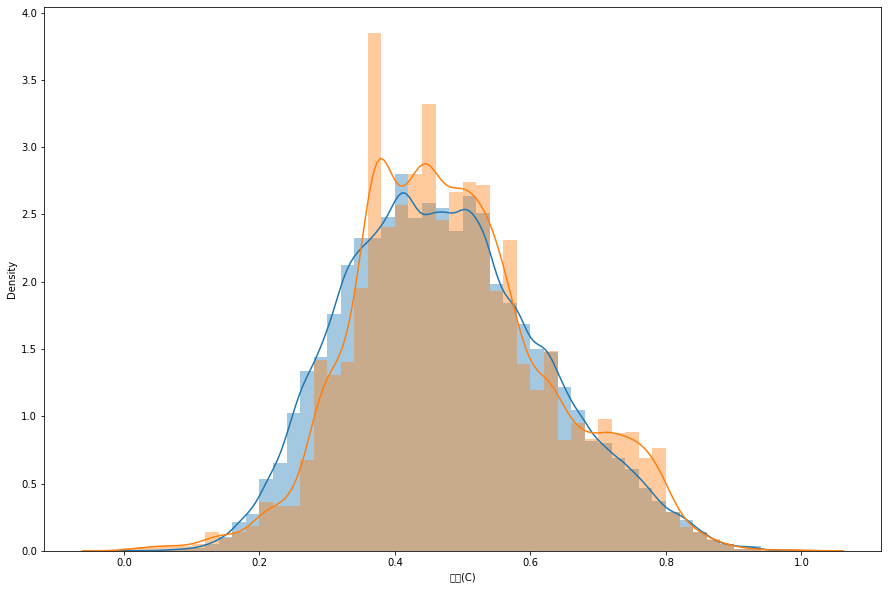

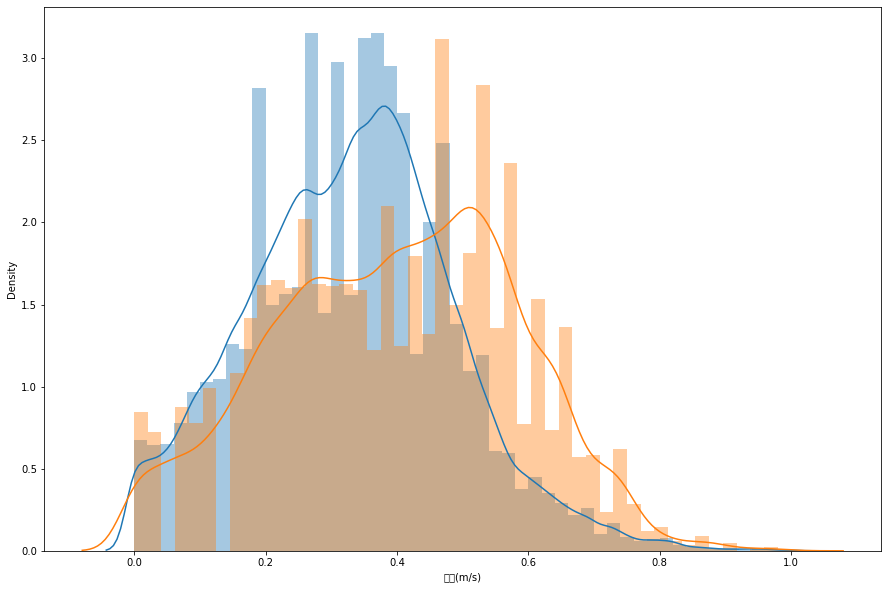

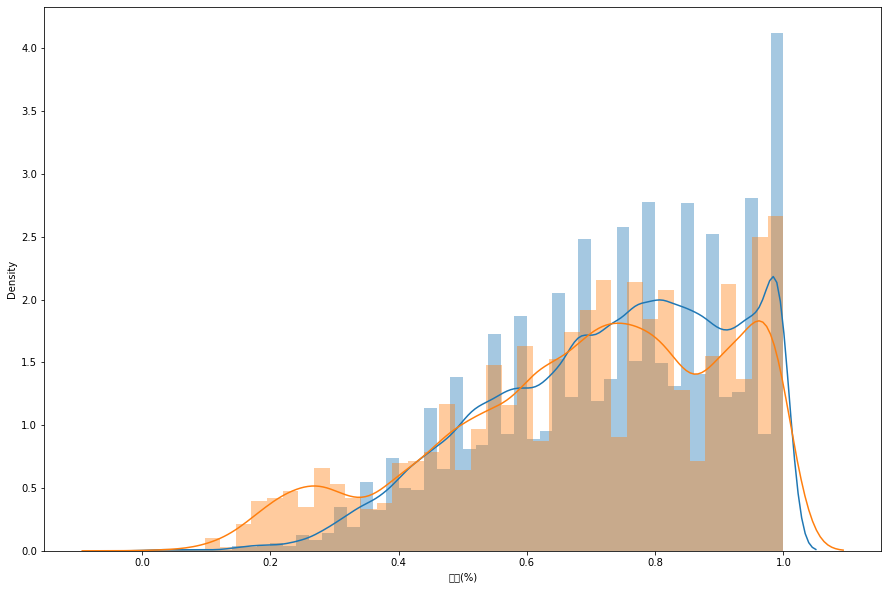

In [7]:
for i in ['기온(C)','풍속(m/s)','습도(%)']:
    plt.figure(figsize=(15,10))
    sns.distplot(train[i])
    sns.distplot(test[i])
    plt.show()

In [10]:
train.iloc[:,:21]

,기온(C),풍속(m/s),습도(%),전력소비량(kWh),month,day,time,연면적(m2),냉방면적(m2),건물기타,...,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트
0,0.281407,0.230993,0.757143,1236.96,6.0,18.0,0.0,0.003616,0.003616,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.271357,0.199275,0.785714,1163.52,6.0,18.0,1.0,0.003616,0.003616,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.256281,0.199275,0.785714,1070.88,6.0,18.0,2.0,0.003616,0.003616,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.256281,0.109669,0.771429,1048.80,6.0,18.0,3.0,0.003616,0.003616,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.261307,0.275035,0.771429,1087.68,6.0,18.0,4.0,0.003616,0.003616,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163195,0.296482,0.182613,0.800000,881.04,8.0,24.0,19.0,0.003659,0.003659,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
163196,0.261307,0.246117,0.800000,798.96,8.0,24.0,20.0,0.003659,0.003659,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
163197,0.206030,0.199275,0.885714,825.12,8.0,24.0,21.0,0.003659,0.003659,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
163198,0.190955,0.068689,0.914286,640.08,8.0,24.0,22.0,0.003659,0.003659,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
from pycaret import regression
regression.setup(data=train.iloc[:,:21],target='전력소비량(kWh)',create_date_columns=['month','day','time'] #  date_features=['일시']# 
                 ,fold_strategy='timeseries',train_size=0.9,session_id=77)
best = regression.compare_models(n_select=5)

,Description,Value
0,Session id,77
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(163200, 21)"
4,Transformed data shape,"(163200, 21)"
5,Transformed train set shape,"(146880, 21)"
6,Transformed test set shape,"(16320, 21)"
7,Numeric features,20
8,Rows with missing values,0.0%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,209.8683,196059.9855,439.1817,0.9689,0.1920,0.1138,9.4040
xgboost,Extreme Gradient Boosting,261.2866,198893.7859,445.2230,0.9684,0.2313,0.1536,2.9780
catboost,CatBoost Regressor,269.8176,202353.6340,449.0140,0.9679,0.2313,0.1593,4.6380
et,Extra Trees Regressor,222.5143,206014.0346,450.6908,0.9673,0.1998,0.1226,6.3890
lightgbm,Light Gradient Boosting Machine,334.9355,270773.8221,520.1849,0.9570,0.2624,0.2034,2.1770
dt,Decision Tree Regressor,240.8142,354764.9824,591.5908,0.9438,0.2513,0.1274,2.2950
gbr,Gradient Boosting Regressor,596.3909,680714.6346,825.0012,0.8918,0.3983,0.3666,2.8230
ada,AdaBoost Regressor,1229.1206,2059207.4458,1434.2623,0.6725,0.7542,1.0190,2.4520
lar,Least Angle Regression,1292.6542,4430965.3250,2104.5354,0.2963,0.6521,0.7237,1.8020
br,Bayesian Ridge,1292.6029,4430997.4000,2104.5430,0.2963,0.6520,0.7238,1.8680


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [31]:
sub = pd.read_csv('./sample_submission.csv')
# sub['answer'] = np.array([i.predict(test.drop('일시',axis=1)) for i in regressors]).mean(0)
sub['answer'] = regressors[-1].predict(test.drop('일시',axis=1))
sub = sub.set_index('num_date_time')
sub.to_csv('./submission.csv')